Generate data by simulating a Lorenz 63 chaotic system

In [1]:
import sys
import pathlib
sys.path.append(str(pathlib.Path('/home/ppiper/Dropbox/local/github/simulai/examples').resolve()))
sys.path.append(str(pathlib.Path('/home/ppiper/Dropbox/local/github/simulai').resolve()))

In [2]:

from sklearn.preprocessing import PolynomialFeatures


In [3]:
from examples.utils.lorenz_solver import lorenz_solver
import numpy as np
dt = 0.005
T_max = 100
rho = 28.0
beta = 8.0 / 3.0
beta_str = '8/3'
sigma = 10.0
n_field = 3

initial_state = np.array([8, -8, 27])[None, :]
lorenz_data, derivative_lorenz_data, time = lorenz_solver(
    rho=rho, dt=dt, T=T_max, sigma=sigma,
    initial_state=initial_state,
    beta=beta, beta_str=beta_str,
    data_path='on_memory', solver='RK45'
)

Performing Collocation Derivation.


In [4]:
from examples.utils.noise import add_noise

np.random.seed(0)
lorenz_data = add_noise(lorenz_data, noise_level=0.0)

In [5]:
from examples.utils.slice_data import sliceDataAlongAxis

data_train, data_test = sliceDataAlongAxis(data=lorenz_data, fractions=[0.5,0.5], axis=0)
time_train, time_test = sliceDataAlongAxis(data=time, fractions=[0.5,0.5], axis=0)
derivative_data_train, derivative_data_test = sliceDataAlongAxis(data=derivative_lorenz_data, fractions=[0.5,0.5], axis=0)

In [55]:
from typing import Any
import sympy as sp
from simulai.math.integration import BRKF78
from scipy import integrate

class SINDy:
    def __init__(
            self, 
            basis_function: object = PolynomialFeatures(degree=2)
        ):
        
        self.basis_function = basis_function

    def _basis_function(self, input_data):
        if len(input_data.shape) == 1:
            input_data = input_data[None]
        return self.basis_function.fit_transform(input_data)

    def build_G(self, input_data):
        return self._basis_function(input_data)
    
    def build_b(self, input_data, time):
        return np.gradient(input_data, time, axis=0)
    
    def fit(self, input_data, time):

        self.G = self.build_G(input_data)
        self.b = self.build_b(input_data, time)

        self.K, self.J = self.G.shape

        self.weigths = np.linalg.lstsq(self.G, self.b, rcond=None)[0]

    def eval(self, input_data, time=None):
        return (self.weigths.T @ self._basis_function(input_data).T).T

    def predict(self, initial_state, time, integrator='BRKF78'):
        integrator = eval(integrator)(right_operator=self)
        return integrator.run(initial_state, time)

    def print(self, weights=None, precision=2, names=None):

        if weights is None:
            weights = self.weigths

        #if names is None:
        #    names = [f'x{i}' for i in range(weights.shape[1])]
        vars = [f'x{i}' for i in range(weights.shape[1])]
        if names is not None:
            new_vars = names
        else:
            new_vars = vars
        names = self.basis_function.get_feature_names_out(names)
        
        for i, wi in enumerate(weights.T):
            
            expr = [f'{wij:+.{precision}f} {n.replace(" ","*")}' for n,wij in zip(names,wi) if f'{abs(wij):.{precision}f}' != f'{abs(0.00):.{precision}f}']
            expr = [e if not e.split(' ')[-1].isnumeric() else ''.join(e.split(' ')[:-1]) for e in expr]
            expr = [e.replace('-','- ') if i > 0 else e.removeprefix('+') for i,e in enumerate(expr)]
            expr = [e.replace('+','+ ') if i > 0 else e.removeprefix('+') for i,e in enumerate(expr)]
            expr = ' '.join(expr)
            expr = f'd{vars[i]}_dt = {expr}'
            
            for var, new_var in zip(vars,new_vars):
                expr = expr.replace(var, new_var)
                
            print(expr)

from scipy.special import legendre

class WSINDy(SINDy):
    def __init__(self, 
            basis_function: object = PolynomialFeatures(degree=2),
            test_function: object = legendre,
            K : int = 10):
        
        self.basis_function = basis_function
        self.test_function = test_function
        self.K = K

    def _test_function(self, input_data, K):
        #p=16
        #q=16
        #1/p**q/q**p*((p+q)/(b+a))**(p+q)*(input_data-a)**p*(b-input_data)**q
        Omega = np.linspace(-1,1, input_data.shape[0])
        Omega = input_data
        test = np.array([
            self.test_function(i)(Omega) for i in range(K) ])
        return test
    
    def _test_function_deriv(self, input_data, K):
        input_data = np.linspace(-1,1, input_data.shape[0])
        test = np.array([
            self.test_function(i).deriv()(input_data) for i in range(K) ])
        return test

    def build_G(self, input_data, time, K):
        Omega = np.linspace(-1,1, time.shape[0])
        test_functions = self._test_function(Omega, K)
        basis_functions = self._basis_function(input_data)
        J = self._basis_function(data_test[0]).shape[1]
        
        G = np.zeros((K,J))
        for k in range(K):
            for j in range(J):
                G[k,j] = integrate.simpson( basis_functions[:,j] * test_functions[k], time)#

        #        G[k,j] = integrate.simpson( y = basis_j* self.test_function(k)(Omega), x = time)
        return G
        #return ( self._test_function(time, K) @ self._basis_function(input_data))
    
    def build_b(self, input_data, time, K):
        #Omega = time
        Omega = np.linspace(-1,1, time.shape[0])
        test_functions_deriv = self._test_function_deriv(Omega, K)
        test_functions = self._test_function(Omega, K)
        
        D = input_data.shape[1]
        b = np.zeros((K, D))
        for k in range(K):
            for d in range(D):
                
                #b[k, d] = - integrate.simpson( input_data[:,d] * test_functions_deriv[k], time) + input_data[-1,d]*test_functions[k][-1] - input_data[0,d]*test_functions[k][0]
 
                # working - but not clever(derivative of input_data)
                #b[k, d] = integrate.simpson( np.gradient(input_data[:,d], time) * test_functions[k], time) 


                # working - but need to improve the derivative computation of test functions
                #test_functions_derivative = np.gradient(test_functions[k], Omega) 
                test_functions_derivative = test_functions_deriv[k]
                b[k, d] = - integrate.simpson( input_data[:,d] * test_functions_derivative, Omega) + input_data[-1,d]*test_functions[k][-1] - input_data[0,d]*test_functions[k][0]
                

                #b[k, d] = - integrate.simpson( y = x_d * self.test_function(k).deriv()(Omega), x = time) + x_d[-1]*self.test_function(k)(Omega)[-1] - x_d[0]*self.test_function(k)(Omega)[0]
        return b
 
        
        #return  - (self._test_function_deriv(time, K) @ input_data) + (self._test_function(time, K)[:,-1,None] @ input_data[-1][None,:]) -(self._test_function(time, K)[:,0,None] @ input_data[0][None,:])
    
    def fit(self, input_data, time):
        self.b = self.build_b(input_data, time, self.K)
        self.G = self.build_G(input_data, time, self.K)

        self.weigths = np.linalg.lstsq(self.G, self.b, rcond=None)[0]
        

In [68]:
wsindy = WSINDy(
    basis_function = PolynomialFeatures(degree=2, include_bias=True), 
    test_function = legendre, 
    K=10)

In [69]:

wsindy.fit(data_train, time_train)
wsindy.print( precision=4)

dx0_dt = -10.0000 x0 + 10.0000 x1
dx1_dt = -0.0001 + 28.0000 x0 - 1.0000 x1 - 1.0000 x0*x2
dx2_dt = -2.6667 x2 + 1.0000 x0*x1


In [9]:
estimated_derivatives = wsindy.eval(data_train)

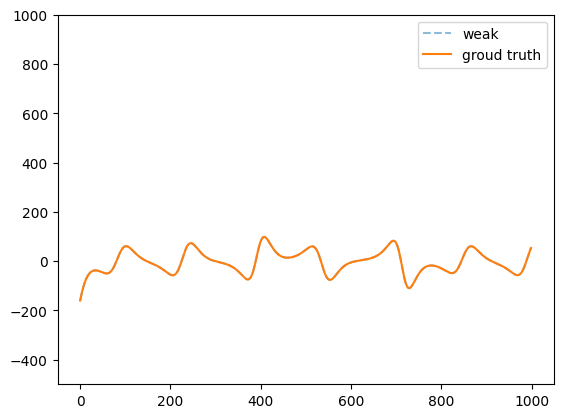

In [10]:


import matplotlib.pyplot as plt


#plt.plot(np.gradient(data_train[:1000,0], time_train[:1000]), label='FD', alpha=0.5)
plt.plot(estimated_derivatives[:1000,0], ls='--', alpha=0.5, label='weak')
plt.plot(derivative_data_train[:1000,0], label='groud truth')
plt.ylim(-500,1000)
plt.legend()

In [11]:
estimated_data = wsindy.predict(initial_state=data_test[0], time=time_test[:1000])

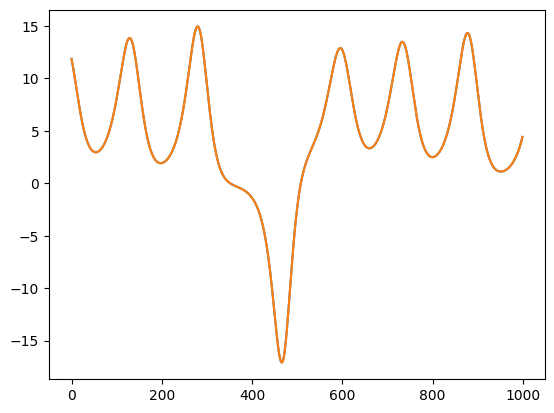

In [12]:
plt.plot(data_test[:1000,0])
plt.plot(estimated_data[:1000,0])

In [31]:
sindy = SINDy()

sindy.fit(data_train, time_train)
sindy.print(precision=4, names=['x','y','z'])

['-0.06 x', '-10.02 y', '+10.02 z']
['-0.08 x', '+27.94 y', '-0.98 z']
['-0.11 x']


In [39]:
sindy.basis_function.get_feature_names_out(None)

array(['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2',
       'x2^2'], dtype=object)

In [14]:
sindy.G.shape

(10001, 10)

In [15]:
sindy.b.shape

(10001, 3)

In [16]:
estimated_derivatives = sindy.eval(lorenz_data)
input_data_derivatives = sindy.b

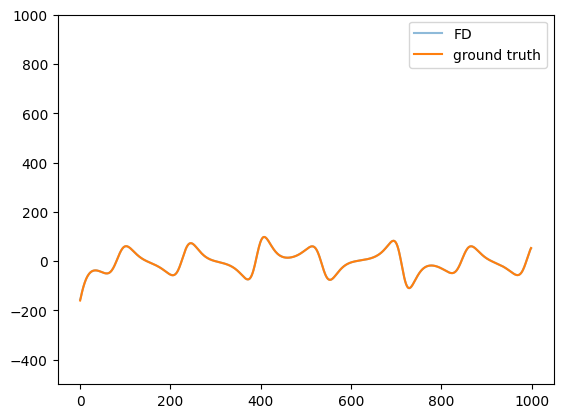

In [17]:
import matplotlib.pyplot as plt

plt.plot(np.gradient(data_train[:1000,0], time_train[:1000]), label='FD', alpha=0.5)
#plt.plot(estimated_derivatives[:1000,0], ls='--', alpha=0.5, label='estimated derivatives')
plt.plot(derivative_data_train[:1000,0], label='ground truth')
plt.ylim(-500,1000)
plt.legend()

In [18]:
estimated_data = sindy.predict(initial_state=data_test[0], time=time_test[:1000])

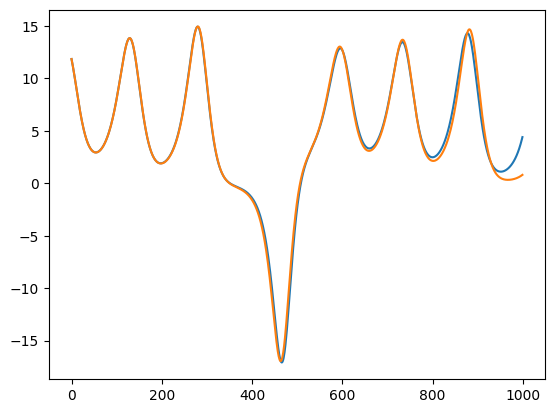

In [19]:
plt.plot(data_test[:1000,0])
plt.plot(estimated_data[:1000,0])

In [23]:
sindy.print()    

dx0_dt = -0.06 x0 - 10.02 x1 + 10.02 x2
dx1_dt = -0.08 x0 + 27.94 x1 - 0.98 x2
dx2_dt = -0.11 x0


In [67]:
import pysindy as ps

model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.1),
    feature_library=ps.PolynomialLibrary(degree=2),
)
model.fit(data_train, t=time_train)
model.print(precision=4)

(x0)' = -9.9945 x0 + 9.9945 x1
(x1)' = 27.9506 x0 + -0.9905 x1 + -0.9986 x0 x2
(x2)' = -2.6647 x2 + 0.9993 x0 x1
